In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy.stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

from scipy.stats import shapiro

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot, add_constant
from statsmodels.formula.api import ols

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import os


## 정제된  product sheet와 order sheet 합치기

In [4]:
df_order_pre = pd.read_csv("order_preprocess_sheet.csv", engine='python', encoding="UTF-8")
df_product_info = pd.read_csv("product_bowl_sheet.csv", engine='python')
print(df_order_pre.columns)
print(df_product_info.columns)

Index(['Unnamed: 0', '결제수단', '공급원가', '교환구분', '네이버 포인트', '배송번호', '배송비 정보',
       '배송시작일', '배송완료일', '사용한 적립금액', '상품구매금액', '상품명', '상품번호', '상품별 추가할인금액',
       '수량', '수령인 주소', '주문 시 회원등급', '주문경로', '주문번호', '주문일시', '주문자ID', '카드사',
       '쿠폰 할인금액', '판매가', '품목번호', '주문년월', '주문분기'],
      dtype='object')
Index(['Column1', '공급사', '과세/면세', '담기', '매입가', '상품명(기본)', '상품코드', '재입고알림',
       '제조사', '카테고리', 'reg_카테고리', '대분류', '판매가', '품절여부', '후기', '한식', '중식', '일식',
       '양식', '분식', '카페', '줄인 상품명'],
      dtype='object')


In [5]:
df_order_pre = df_order_pre.loc[:, ["상품명", "상품번호", "주문년월", "수량"]]
df_product_info = df_product_info.loc[:,["상품코드", "줄인 상품명"]]
df_product_info.columns = ["상품번호", "줄인 상품명"]
print(df_order_pre.columns)
print(df_product_info.columns)

Index(['상품명', '상품번호', '주문년월', '수량'], dtype='object')
Index(['상품번호', '줄인 상품명'], dtype='object')


In [6]:
new_order_sheet = pd.merge(df_order_pre, df_product_info, on="상품번호")
new_order_sheet.head()

,상품명,상품번호,주문년월,수량,줄인 상품명
0,195파이 탕용기 소 300개 1set(2박스),1077,18년12월,1,탕 용기
1,195파이 탕용기 소 300개 1set(2박스),1077,18년12월,1,탕 용기
2,195파이 탕용기 소 300개 1set(2박스),1077,19년01월,1,탕 용기
3,195파이 탕용기 소 300개 1set(2박스),1077,19년01월,1,탕 용기
4,195파이 탕용기 소 300개 1set(2박스),1077,19년01월,2,탕 용기


In [73]:
pivot_order = pd.pivot_table(data=new_order_sheet, index=('주문년월'),
                             values=['수량'],aggfunc='sum').reset_index()
start_index = pivot_order[pivot_order['주문년월']=='17년01월'].index 
end_index = pivot_order[pivot_order['주문년월']=='19년06월'].index
pivot_order = pivot_order.drop(start_index)
pivot_order = pivot_order.drop(end_index)
pivot_order = pivot_order[['주문년월','수량']]
pivot_order.head()

,주문년월,수량
1,17년02월,16
2,17년03월,26
3,17년04월,25
4,17년05월,43
5,17년06월,95


In [74]:
pivot_order['주문년월']=pd.to_datetime(pivot_order['주문년월'],format='%y년%m월')
order_dataset = pivot_order.set_index('주문년월')
order_dataset.head()

,수량
주문년월,
2017-02-01,16
2017-03-01,26
2017-04-01,25
2017-05-01,43
2017-06-01,95


### train, test 데이터 셋 만들기 + 모델 돌리기

In [75]:
train_size = 0.8
len_dataset = len(order_dataset.index)
mask = (np.arange(len_dataset)/len_dataset) < train_size

df_train = order_dataset[mask]
df_test = order_dataset[~mask]

print(df_train.shape)
print(df_test.shape)

(23, 1)
(5, 1)


c:\users\leade\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\leade\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D2.수량   No. Observations:                   21
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -143.435
Method:                       css-mle   S.D. of innovations            219.417
Date:                Mon, 27 Apr 2020   AIC                            294.870
Time:                        00:17:32   BIC                            299.048
Sample:                    04-01-2017   HQIC                           295.776
                         - 12-01-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          17.6721     21.849      0.809      0.429     -25.151      60.495
ar.L1.D2.수량    -0.8912      0.194     -4.584      0.000      -1.272      -0.510
ar.L2.D2.수량    -0.3825      0.198     -1.933    

c:\users\leade\miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\leade\miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\leade\miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\leade\miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\leade\miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\leade\miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44050 missing from

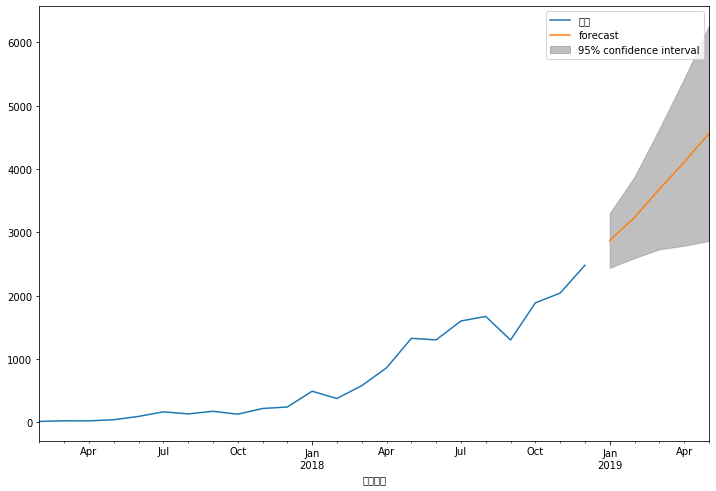

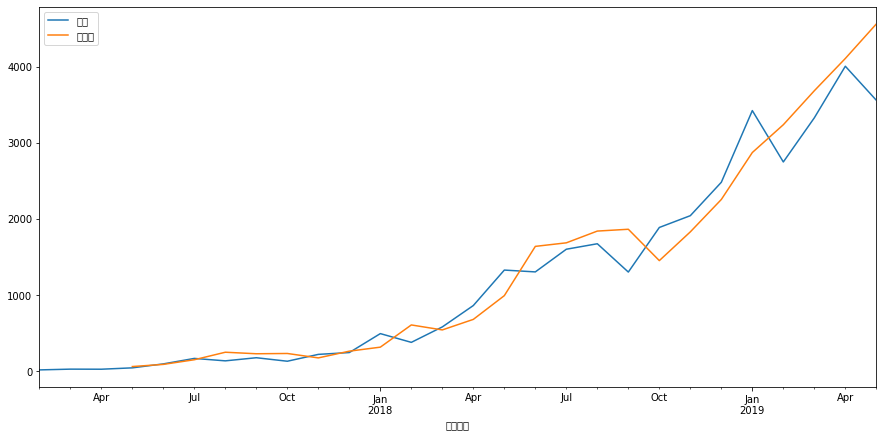

In [78]:
model_all = ARIMA(df_train,order=(2,2,0))

result_all = model_all.fit(trend='c', fulloutput=True)
print(result_all.summary())

start_time = df_test.index.min()
end_time = df_test.index.max()

fig , ax = plt.subplots(figsize = (12,8))
# ax
ax= df_train.plot(ax=ax)
fig = result_all.plot_predict(start = start_time, end=end_time, ax=ax , plot_insample= False)

start_time = pd.to_datetime("2017-05-01")
end_time = df_test.index.max()

y_pred = result_all.predict(start=start_time,end=end_time,typ = 'levels')
y_pred
df_merge=order_dataset
df_merge["예측값"]=y_pred
df_merge.head()


df_merge.plot(y=['수량',"예측값"],figsize=(15,7))

##  특정 용기에 대해서

In [7]:
new_order_sheet.head()

,상품명,상품번호,주문년월,수량,줄인 상품명
0,195파이 탕용기 소 300개 1set(2박스),1077,18년12월,1,탕 용기
1,195파이 탕용기 소 300개 1set(2박스),1077,18년12월,1,탕 용기
2,195파이 탕용기 소 300개 1set(2박스),1077,19년01월,1,탕 용기
3,195파이 탕용기 소 300개 1set(2박스),1077,19년01월,1,탕 용기
4,195파이 탕용기 소 300개 1set(2박스),1077,19년01월,2,탕 용기


In [8]:
new_order_sheet["줄인 상품명"].value_counts()

탕 용기       7216
다용도 컵      5101
면 용기       4618
도시락 용기     3582
죽 용기       2127
반찬 용기      1008
찜 용기        977
아이스컵 뚜껑     793
아이스컵        740
원형 용기       633
샐러드 용기      484
단무지 용기      197
스트로폼 용기     118
알루미늄 용기      73
밀폐 용기        57
냄비 뚜껑        45
음료 용기        45
타원 용기        32
컵 뚜껑         31
빨대           24
호프 용기        23
회 용기         22
전자렌지 용기      20
홀더           12
펄프 용기         6
쿠키 용기         2
Name: 줄인 상품명, dtype: int64

In [9]:
is_bowl = new_order_sheet["줄인 상품명"] == "탕 용기 "
some_bowl_sheet = new_order_sheet[is_bowl]
some_bowl_sheet

,상품명,상품번호,주문년월,수량,줄인 상품명
0,195파이 탕용기 소 300개 1set(2박스),1077,18년12월,1,탕 용기
1,195파이 탕용기 소 300개 1set(2박스),1077,18년12월,1,탕 용기
2,195파이 탕용기 소 300개 1set(2박스),1077,19년01월,1,탕 용기
3,195파이 탕용기 소 300개 1set(2박스),1077,19년01월,1,탕 용기
4,195파이 탕용기 소 300개 1set(2박스),1077,19년01월,2,탕 용기
...,...,...,...,...,...
27447,고강도 감자탕용기 특대 100개 1set(2박스),1377,19년03월,1,탕 용기
27448,고강도 감자탕용기 특대 100개 1set(2박스),1377,19년04월,1,탕 용기
27449,고강도 감자탕용기 특대 100개 1set(2박스),1377,19년04월,1,탕 용기
27450,고강도 감자탕용기 특대 100개 1set(2박스),1377,19년04월,1,탕 용기


In [23]:
bowl_pivot_order = pd.pivot_table(data=some_bowl_sheet, index=('주문년월'),
                             values=['수량'],aggfunc='sum').reset_index()
start_index = bowl_pivot_order[bowl_pivot_order['주문년월']=='17년05월'].index 
end_index = bowl_pivot_order[bowl_pivot_order['주문년월']=='19년06월'].index
bowl_pivot_order = bowl_pivot_order.drop(start_index)
bowl_pivot_order = bowl_pivot_order.drop(end_index)
bowl_pivot_order = bowl_pivot_order[['주문년월','수량']]
bowl_pivot_order.head()

,주문년월,수량
0,17년06월,3
1,17년07월,1
2,17년10월,1
3,17년11월,26
4,17년12월,25


In [17]:
bowl_pivot_order['주문년월']=pd.to_datetime(bowl_pivot_order['주문년월'],format='%y년%m월')
bowl_order_dataset = bowl_pivot_order.set_index('주문년월')
bowl_order_dataset.head()

,수량
주문년월,
2017-06-01,3
2017-07-01,1
2017-10-01,1
2017-11-01,26
2017-12-01,25


In [18]:
train_size = 0.8
len_dataset = len(bowl_order_dataset.index)
mask = (np.arange(len_dataset)/len_dataset) < train_size

df_bowl_train = bowl_order_dataset[mask]
df_bowl_test = bowl_order_dataset[~mask]

print(df_bowl_train.shape)
print(df_bowl_test.shape)

(18, 1)
(4, 1)


                             ARIMA Model Results                              
Dep. Variable:                  D2.수량   No. Observations:                   16
Model:                 ARIMA(2, 2, 0)   Log Likelihood                 -92.975
Method:                       css-mle   S.D. of innovations             76.303
Date:                Mon, 27 Apr 2020   AIC                            193.950
Time:                        19:55:23   BIC                            197.041
Sample:                             2   HQIC                           194.109
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.7378      7.579      1.021      0.326      -7.116      22.592
ar.L1.D2.수량    -0.9603      0.184     -5.208      0.000      -1.322      -0.599
ar.L2.D2.수량    -0.7197      0.163     -4.420    

c:\users\leade\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\leade\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyError: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'

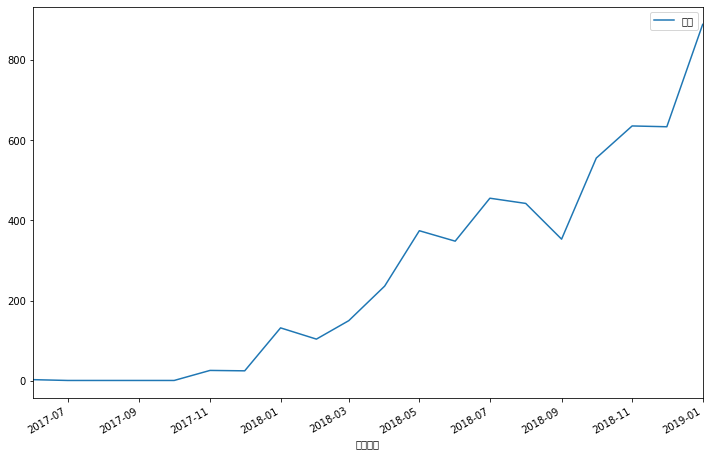

In [19]:
bowl_model_all = ARIMA(df_bowl_train,order=(2,2,0))

bowl_result_all = bowl_model_all.fit(trend='c', fulloutput=True)
print(bowl_result_all.summary())

start_time = df_bowl_test.index.min()
end_time = df_bowl_test.index.max()

fig , ax = plt.subplots(figsize = (12,8))
# ax
ax= df_bowl_train.plot(ax=ax)
fig = bowl_result_all.plot_predict(start = start_time, end=end_time, ax=ax , plot_insample= False)

start_time = pd.to_datetime("2017-05-01")
end_time = df_bowl_test.index.max()

y_bowl_pred = bowl_result_all.predict(start=start_time,end=end_time,typ = 'levels')
y_bowl_pred
df_bowl_merge=bowl_order_dataset
df_bowl_merge["예측값"]=y_bowl_pred
df_bowl_merge.head()


df_bowl_merge.plot(y=['수량',"예측값"],figsize=(15,7))